<a href="https://colab.research.google.com/github/CMDRZero/DataScienceFundamentalsClass/blob/main/GranBellU4Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting deaths except by country

The first thing I needed to do in order to predict deaths is to first import a bunch of libraries and then preprocess my data, because as it is, its a mess and wont work.

In [1]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 642.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [2]:
import arviz as az
import pymc as pm     #The engine of prediction
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import preliz as pz   #We are using this so I can make the nice graphs of priors and likelyhoods
import urllib.request #Using advice from stack exchange

In [3]:
url = 'https://raw.githubusercontent.com/CMDRZero/DataScienceFundamentalsClass/main/countryage.txt'
data = eval(urllib.request.urlopen(url).read()) #I did preprocessing in a seperate file and duped the repr of the data.

Preprocessing code was this
```import csv
with open('ages.csv',encoding = 'utf-8') as file:
    reader = csv.reader(file)
    data = list(reader)
ages = [1+int(data[i][9]) for i in range(1,len(data)) if data[i][9] != '']
b=[int(x[6])//100 for x in data[1:]]

cats = {}

for row in data[1:]:
    mcat = row[4]
    for cat in mcat.split('; '):
        cats[cat] = cats.get(cat, [])
        cats[cat].append(row[9])

cs=list(cats.keys())
m=[c for c in cs if len(cats[c]) > 100] #Filter to only countries with 100+ deaths

mc = {cat:cats[cat] for cat in m}

with open('countryage.txt', 'w',encoding = 'utf-8') as f:
    f.write(repr(mc))
```

Since its less about data science and more just data reorganization, I wont go into terrible depth in explaining my code here, but it takes the data file I have stored on my local machine and imports it as a CSV, scraping out all of the ages at death and countries, and packing it into a dictionary. Since some deathes are attributed to multiple countries, I split along `; ` and put that death in all of those countries tables. I considered this the proper way of handling this information as if a person is associated with multiple countries, their death is likely related as well. But this is a potential big source for change in the future.

In [4]:
common = []
pairs = [(key, data[key]) for key in data]
spairs = sorted(pairs, key=lambda x: len(x[1]), reverse = True) #Sort the pairs of country and deaths by number of deaths
keys = [k for k,d in spairs[:30]] #Select the top 30 countries by death count
for cat in keys:
  dat = data[cat]
  np.random.shuffle(dat)  #Shuffle them so I can subsample them evenly
  for v in dat[:1000]:  #Select off first 1000
    if v != '':
      common.append((int(v)+1, cat))  #Add 1 to the age because Weibull crashes on the value 0

Then I download that trimmed down file I uploaded and do some more post processing here where I trim it down again as needed based on the amount of time I'm willing to let the engine work.

In [5]:
frame = pd.DataFrame(common)  #Put it into a frame for usage later
frame

0                1
0      60                 
1      53                 
2      82                 
3      91                 
4      61                 
...    ..              ...
29995  57  Austria-Hungary
29996  95  Austria-Hungary
29997  65  Austria-Hungary
29998  78  Austria-Hungary
29999  66  Austria-Hungary

[30000 rows x 2 columns]

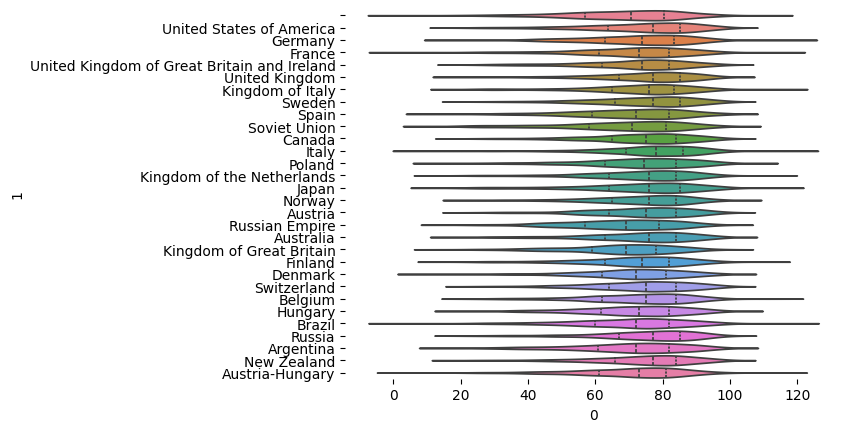

In [6]:
sns.violinplot(frame, x=0, y=1, inner='quart',hue=1)
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

This is actually like the 10th iteration of this plot, in the past I went for every country with more than 100 deaths and just clamped their data, but this ended up causing alot of problems later, and also make this graph unintelligable. Here, while it is a little compact, is still readable and you can see the tails and medians of deaths by country well.

However, this also wierdly illustrates a problem, which is country duplication, see: `United Kingdom of Great Britain and Ireland` and `United Kingdom`, and `Kingdom of Great Britain`. I've decided to let this go as the duplicated countries seem to have unique enough distributions that there might be some internal process making them unique in not just name but shape.

# Visualizations

<Axes: >

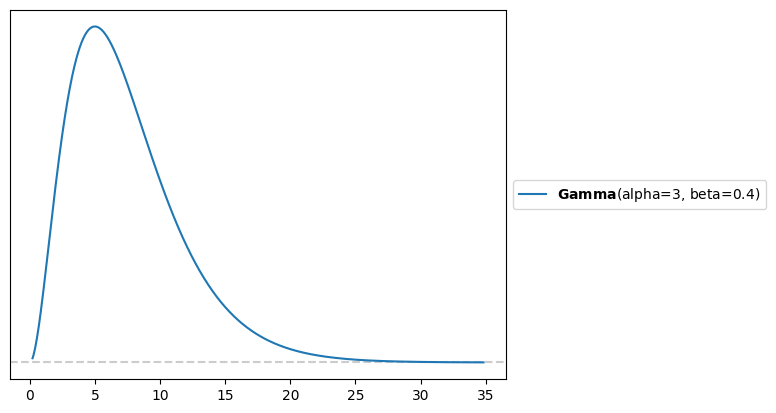

In [26]:
pz.Gamma(3, .4).plot_pdf()  #Shape parameter, being around 5 works best, but sometimes goes higher, and doesnt make sense to be negative.

<Axes: >

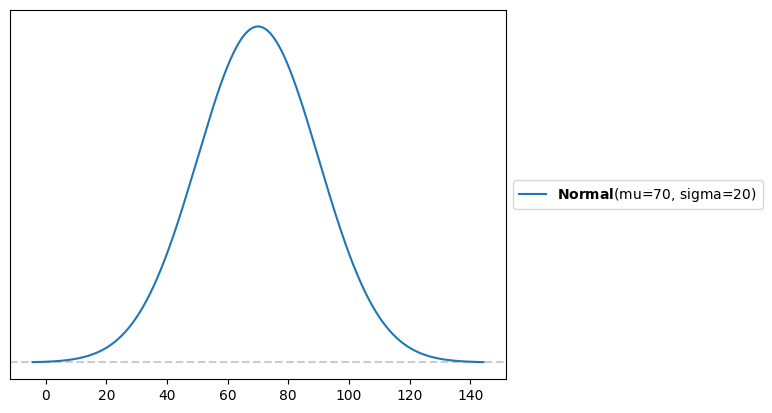

In [28]:
pz.Normal(70, 20).plot_pdf()  #Scale parameter, close to the mean but not quite, scales the graph, around 70 works very well

<Axes: >

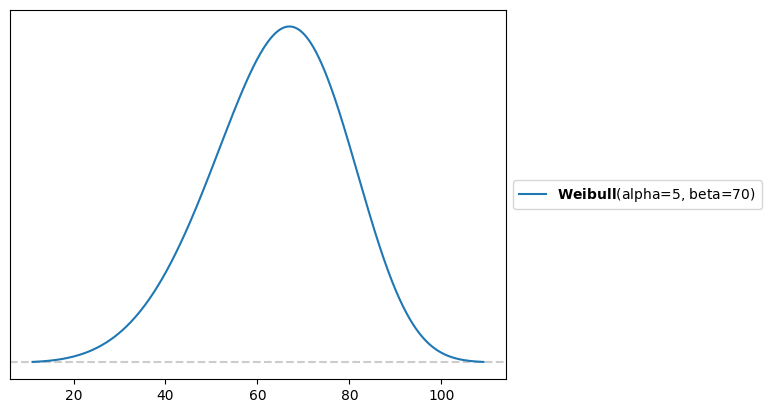

In [30]:
pz.Weibull(5, 70).plot_pdf()  #What our Weibull might look like

# Hyperpriorless Model

In [32]:
encode = pd.Categorical(frame[1])
idx = encode.codes
coords = {'cc': encode.categories}

Now just to make sure that I'm doing each step correct, I'll implement the simplest model that has distinct dimensions to predict along without any hyperpriors, this should just be adding in dims and setting up coords.

In [33]:
with pm.Model(coords = coords) as nh_model:
  k = pm.Normal('k', mu = 70, sigma = 20, dims = 'cc') #I'm using the values from my last iteration of this data which worked well
  l = pm.Gamma('l', 3, .4, dims = 'cc')

  y = pm.Weibull('y', alpha = l[idx], beta = k[idx], observed = frame[0])

  samples = pm.sample()

Output()

Output()

Now just a sanity check to make sure my model is as simple as possible.

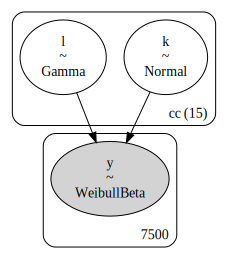

In [34]:
pm.model_to_graphviz(nh_model)

Now lets sample it and see how that sqaures up against our actual data.

In [35]:
pm.sample_posterior_predictive(samples, model=nh_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

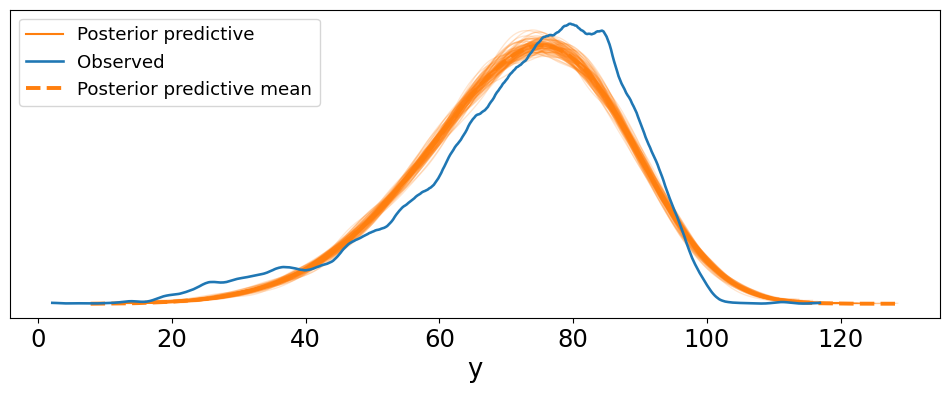

In [36]:
az.plot_ppc(samples, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#plt.xlim([-10,10]) #:O thx chatgpt ("Is it possible to limit the range displayed on a python avriz ppc graph")

Ok, so it doesn't do perfectly, but its fine enough if thats all I wanted to do. I already know that a Weibull models the process of deaths well enough, even if I had hoped to use my custom distribution here (I tried for two days and the code kept fighting me).

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'l'}>, <Axes: title={'center': 'l'}>]],
      dtype=object)

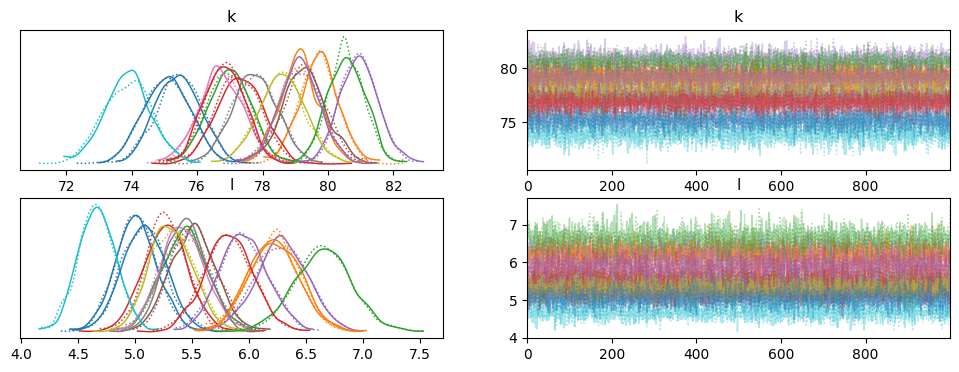

In [37]:
az.plot_trace(samples)

Now just to make sure that nothing was attrociously wrong in the runtime even tho it did not list any divergences

In [38]:
az.rhat(samples).to_dataarray().to_numpy()

array([[0.99934631, 0.99957191, 0.99977485, 1.00029704, 1.00173451,
        1.00261896, 1.00066682, 0.99978163, 1.00007189, 1.00266653,
        0.9995847 , 1.00087931, 1.00196623, 0.99920214, 1.00161041],
       [1.00086001, 1.00028053, 1.00088364, 1.00174179, 1.00294345,
        0.99933984, 1.00028792, 1.00293324, 0.99986393, 1.00047858,
        0.99938239, 1.00051678, 0.99946687, 0.99976174, 0.999531  ]])

All of our rhat values are very good

In [39]:
az.rhat(samples).data_vars

Data variables:
    k        (cc) float64 120B 0.9993 0.9996 0.9998 1.0 ... 1.002 0.9992 1.002
    l        (cc) float64 120B 1.001 1.0 1.001 1.002 ... 0.9995 0.9998 0.9995

Here I just listed out all of our countries in order so I could find a corespondence between rhat and a country, but as none were a problem, I didn't end up doing that

In [40]:
coords[list(az.rhat(samples).coords)[0]]

Index(['', 'Canada', 'France', 'Germany', 'Italy', 'Japan', 'Kingdom of Italy',
       'Kingdom of the Netherlands', 'Poland', 'Soviet Union', 'Spain',
       'Sweden', 'United Kingdom',
       'United Kingdom of Great Britain and Ireland',
       'United States of America'],
      dtype='object')

And now to visualize our parameters, here we have just two and looking at them, they seem reasonable enough. (Also making this look good took a really long time)

array([<Axes: >], dtype=object)

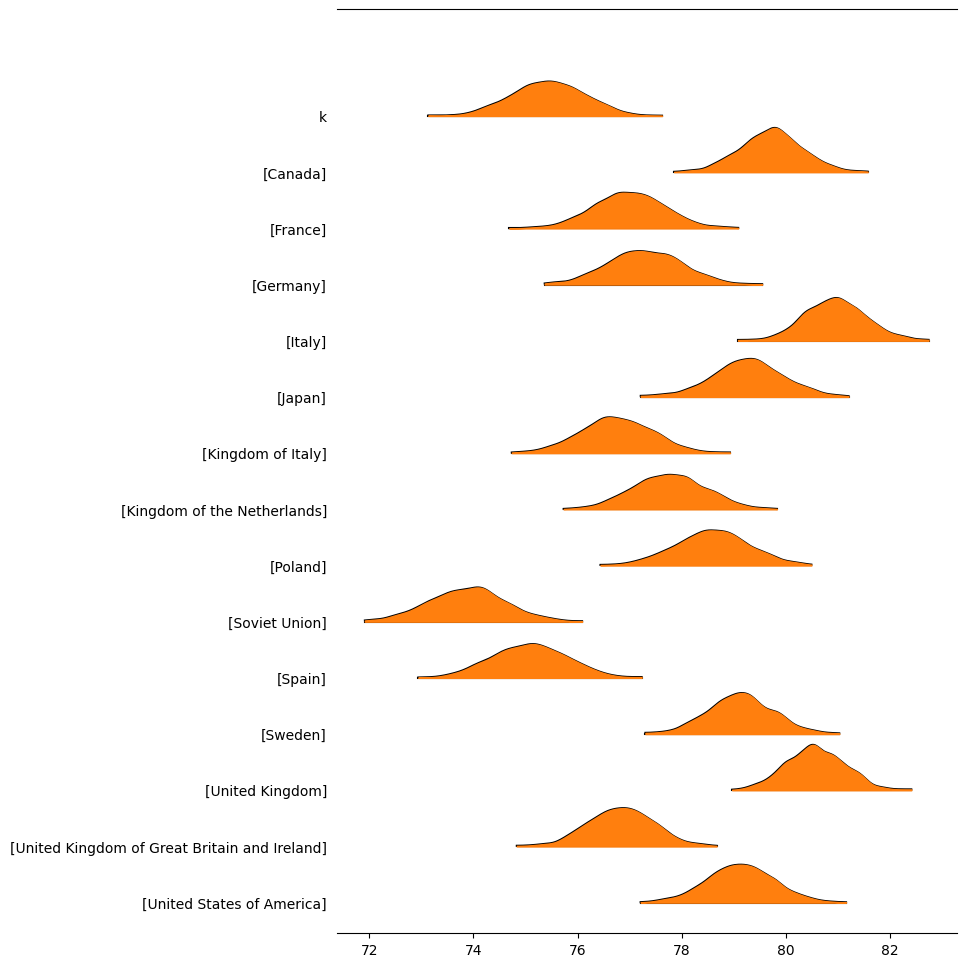

In [41]:
az.plot_forest(samples, var_names=['k'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C1"], figsize=(8, 12))

Again, here we see a distinction between Great Britain and the UK, with drastically different k values, that are well over 3 standard deviations away from each other.

array([<Axes: >], dtype=object)

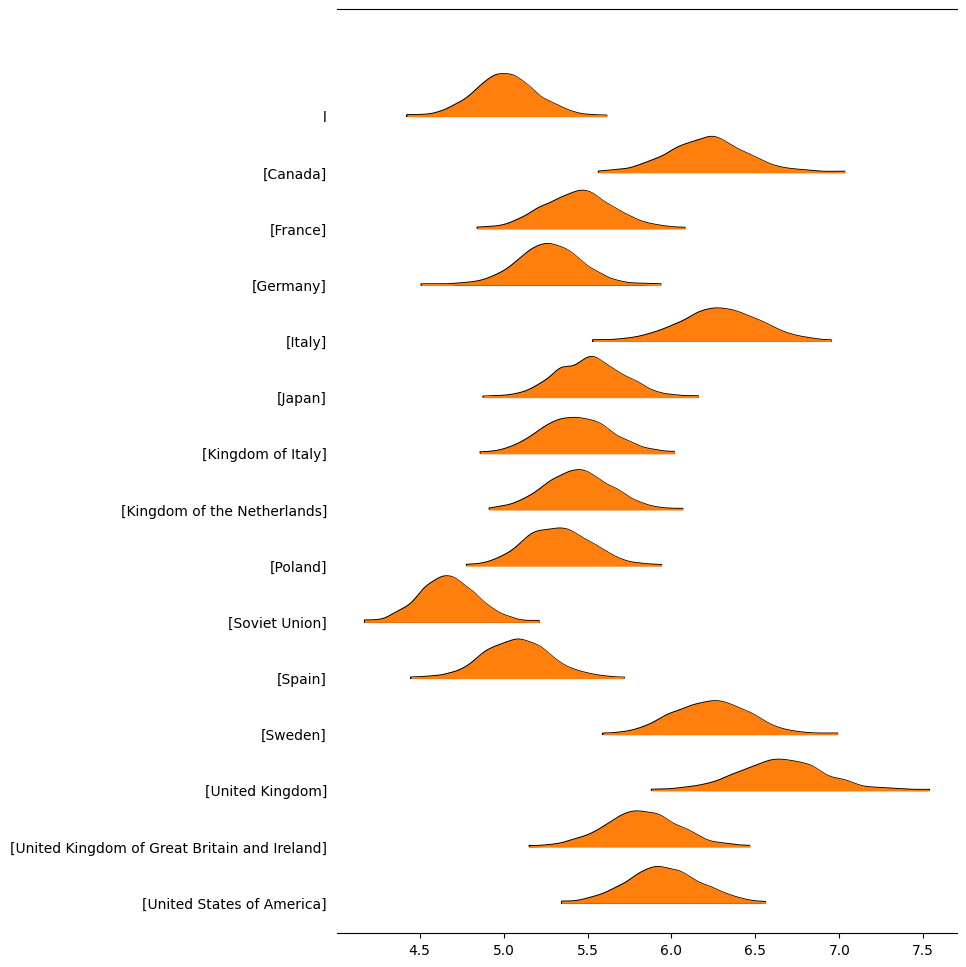

In [42]:
az.plot_forest(samples, var_names=['l'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C1"], figsize=(8, 12))

Looking at this graph as well, its a little more compressed than our k values, but thats to be expected, one wouldn't expect l to vary much, as this models how quickly death rate ramps up with time.

# Non-Heirarchical Model

Now lets use hyperpriors to give our model more potential to map to our data.

In [11]:
common = []
pairs = [(key, data[key]) for key in data]
spairs = sorted(pairs, key=lambda x: len(x[1]), reverse = True)
keys = [k for k,d in spairs[:15]]
for cat in keys:
  dat = data[cat]
  np.random.shuffle(dat)
  for v in dat[:500]:
    if v != '':
      common.append((int(v)+1, cat))

I'm just shortening the choice of data I use, it turns out that hyperpriors really slow things down, so I need to drop it down to 15 countries with 500 data points each or else this wont finish quickly.

In [12]:
frame = pd.DataFrame(common)

In [13]:
encode = pd.Categorical(frame[1])
idx = encode.codes
coords = {'cc': encode.categories}

When picking hyperpriors, I didnt have a good intuition for what curves would work well, I knew that a normal dist and gamma worked well with a Weibull, but for those, I was unsure and used a normal and half normal for both.

In [48]:
#Define our model using the python `with` syntax
with pm.Model(coords = coords) as nh_hp_model:
  k_mu = pm.Normal('k_mu', mu = 70, sigma = 20, dims = 'cc')
  k_sigma = pm.HalfNormal('k_sigma', sigma = 20, dims = 'cc')

  l_alpha = pm.Normal('l_alpha', mu = 3, sigma = .4, dims = 'cc')
  l_beta = pm.HalfNormal('l_beta', sigma = .4, dims = 'cc')

  k = pm.Normal('k', mu = k_mu, sigma = k_sigma, dims = 'cc')
  l = pm.Gamma('l', l_alpha, l_beta, dims = 'cc')

  y = pm.Weibull('y', alpha = l[idx], beta = k[idx], observed = frame[0])

  hp_samples = pm.sample(target_accept=.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Ok, so we got some divergences, but to be honest, I dont actually know whats going wrong. Even after turning up my `target_accept`, it still kept diverging. This seemed to significantly impair runtime, but I suspect I used bad hyperpriors, I'll revisit this at the very end.

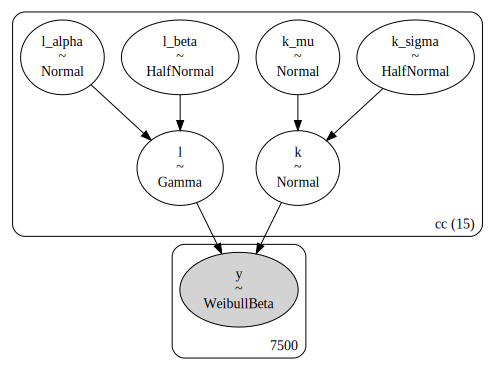

In [49]:
pm.model_to_graphviz(nh_hp_model)

In [52]:
pm.sample_posterior_predictive(hp_samples, model=nh_hp_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Lets plot it now, sure it gave some problems but I dont think it'll be that bad

<Axes: xlabel='y'>

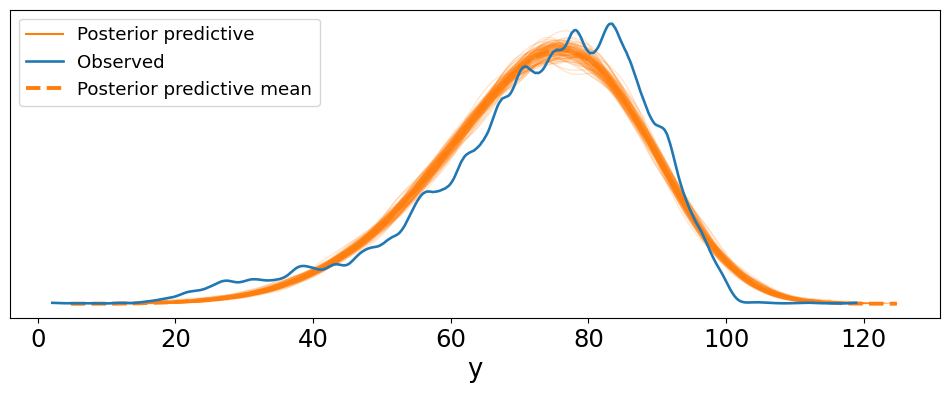

In [53]:
az.plot_ppc(hp_samples, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Plotting trace and anaylzing Rhat will hopefully give us insignt into what items were causing difficulties.

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'k_mu'}>,
        <Axes: title={'center': 'k_mu'}>],
       [<Axes: title={'center': 'k_sigma'}>,
        <Axes: title={'center': 'k_sigma'}>],
       [<Axes: title={'center': 'l'}>, <Axes: title={'center': 'l'}>],
       [<Axes: title={'center': 'l_alpha'}>,
        <Axes: title={'center': 'l_alpha'}>],
       [<Axes: title={'center': 'l_beta'}>,
        <Axes: title={'center': 'l_beta'}>]], dtype=object)

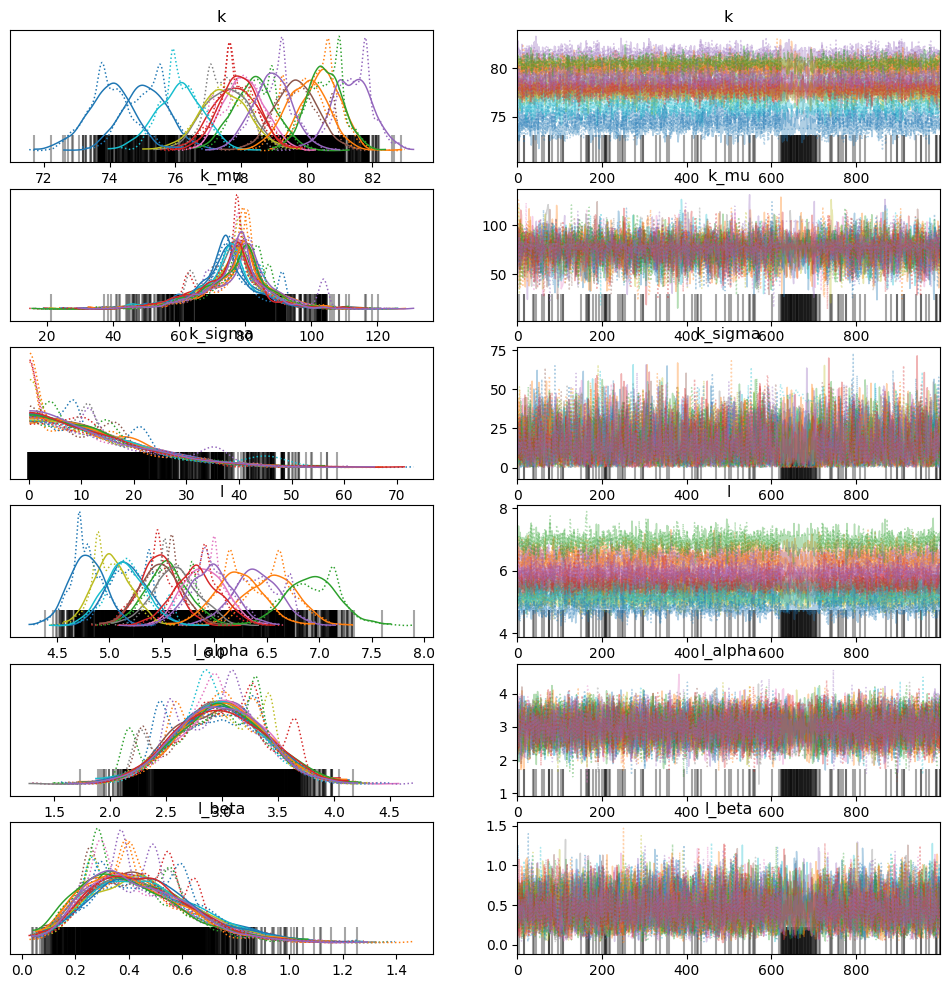

In [58]:
az.plot_trace(hp_samples)

Ok, thats alot of wierd black bars, I wonder if those are divergencies, however I didnt see those at all in my exercises or notes, so I'm not fully sure. Lets plot rhat and find anything above like 1.05

In [59]:
az.rhat(hp_samples).to_dataarray().to_numpy()

array([[1.00163701, 1.00104671, 1.00330332, 1.01154156, 1.00070582,
        1.01171678, 1.01163729, 1.00818637, 1.00167048, 1.00504879,
        1.00040945, 1.00351212, 1.00156621, 1.00124207, 1.00173081],
       [1.01075074, 1.00193333, 1.01153578, 1.00467613, 1.00383355,
        1.00207365, 1.00905403, 1.01159715, 1.00919143, 1.00810153,
        1.00268464, 1.01220248, 1.00201735, 1.00847782, 1.01985917],
       [1.00245089, 1.01099716, 1.00552948, 1.0061434 , 1.00992864,
        1.00314333, 1.0127333 , 1.01452937, 1.02219828, 1.01455744,
        1.0057954 , 1.0173822 , 1.00221095, 1.01469132, 1.01657864],
       [1.00436089, 1.00220577, 1.00529907, 1.01192411, 1.006728  ,
        1.00472814, 1.00163963, 1.003466  , 1.00269633, 1.01536721,
        1.00315876, 1.00055005, 1.00439647, 1.00131498, 1.00108848],
       [1.0116735 , 1.00300444, 1.00995207, 1.00315417, 0.9997149 ,
        1.00805803, 1.01379872, 1.00929586, 1.00346362, 1.00302677,
        1.00272159, 1.00282163, 0.99965485, 

Ok... there's none, if I had to guess that probably means that our models were failing universally and slightly, with no culprits being in particularlly bad.

Maybe the forest plot can give us some insight.

array([<Axes: >], dtype=object)

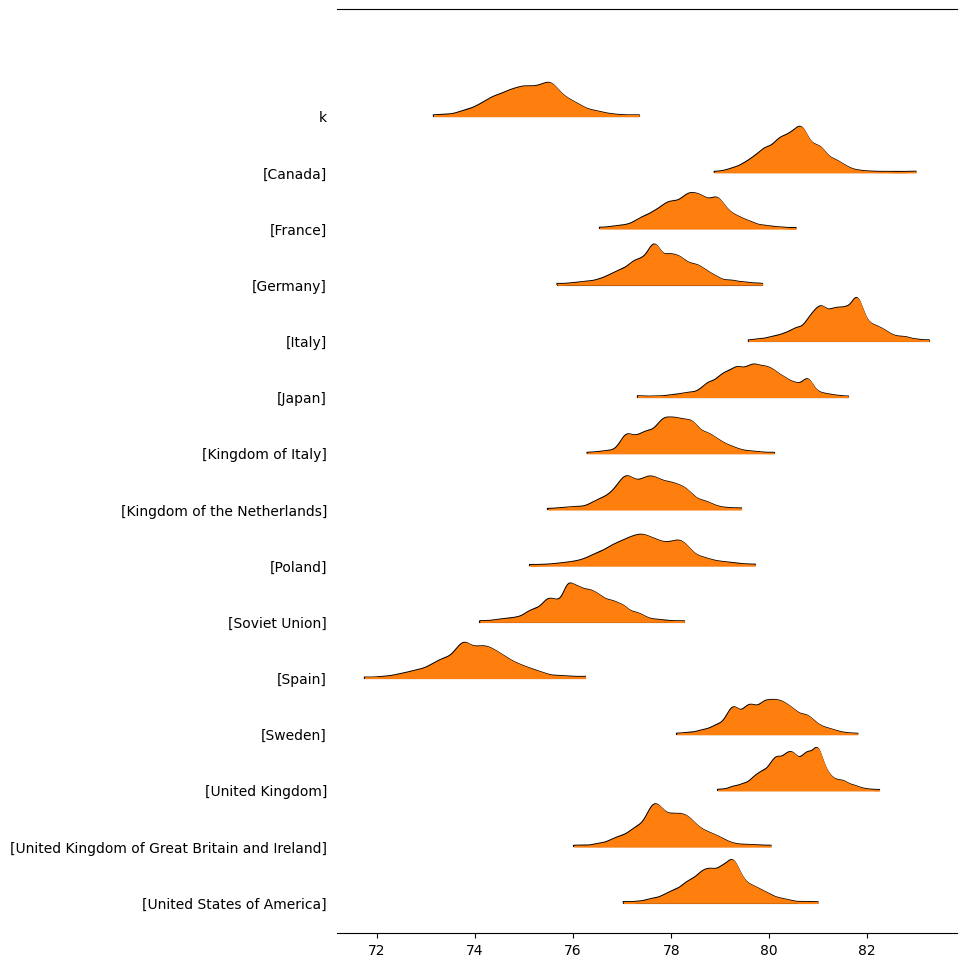

In [61]:
az.plot_forest(hp_samples, var_names=['k'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C1"], figsize=(8, 12))

array([<Axes: >], dtype=object)

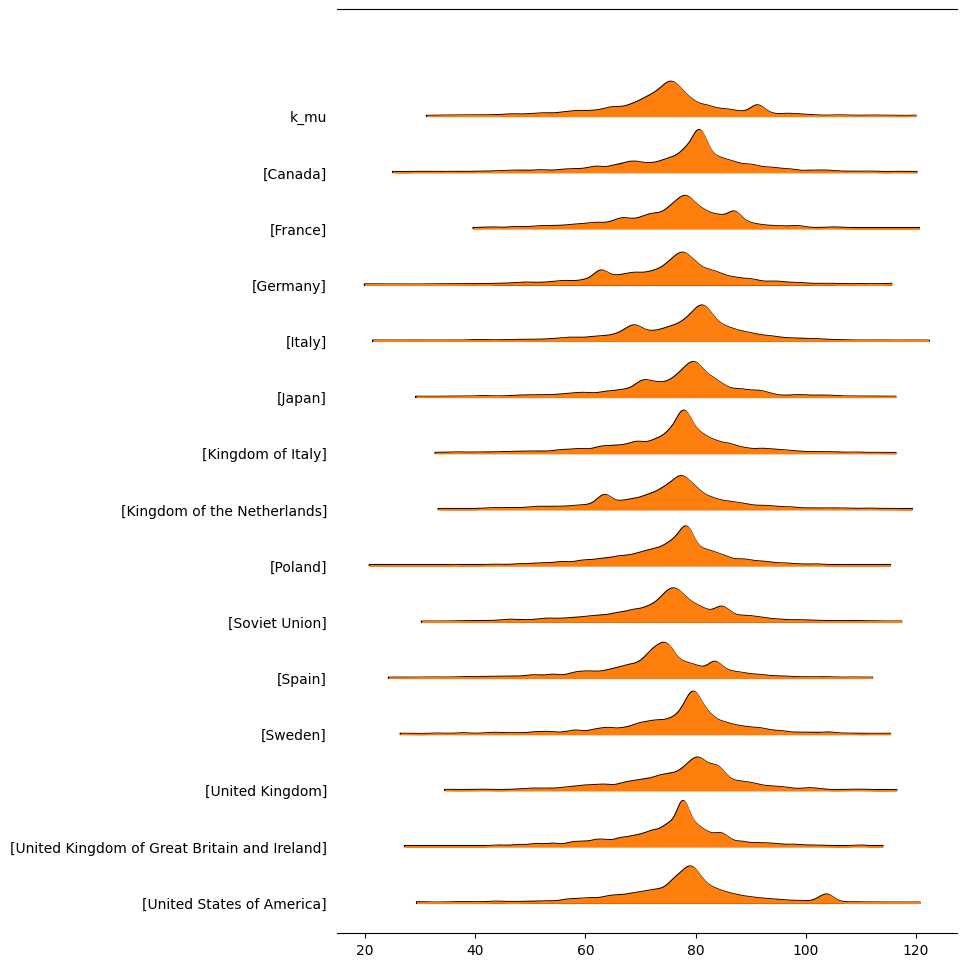

In [62]:
az.plot_forest(hp_samples, var_names=['k_mu'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C1"], figsize=(8, 12))

Ok, so our heirarchical model is struggling alot, and if we look at our ridge plots we see a very wide distribution and some of them are bimodal, like the USA.

# Heirarchical Model

Ok, even tho there was some problems, maybe making it heirarchical will fix everything? I'll just remove the independence between hyperpriors as it makes sense that countries would "sample" their priors from a common hyperprior, we're all humans in the end.

In [12]:
#Define our model using the python `with` syntax
with pm.Model(coords = coords) as h_hp_model:
  k_mu = pm.Normal('k_mu', mu = 70, sigma = 20)
  k_sigma = pm.HalfNormal('k_sigma', sigma = 20)

  l_alpha = pm.Normal('l_alpha', mu = 3, sigma = .4)
  l_beta = pm.HalfNormal('l_beta', sigma = .4)

  k = pm.Normal('k', mu = k_mu, sigma = k_sigma, dims = 'cc')
  l = pm.Gamma('l', l_alpha, l_beta, dims = 'cc')

  y = pm.Weibull('y', alpha = l[idx], beta = k[idx], observed = frame[0])

  h_hp_samples = pm.sample(target_accept=.95)

Output()

Output()

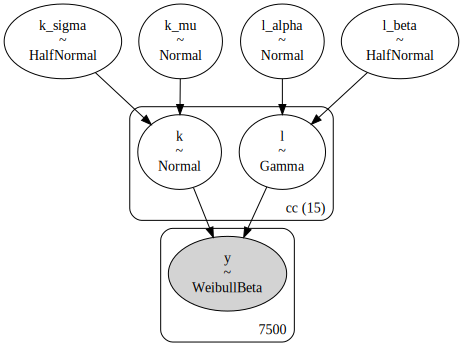

In [13]:
pm.model_to_graphviz(h_hp_model)

In [17]:
pm.sample_posterior_predictive(h_hp_samples, model=h_hp_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

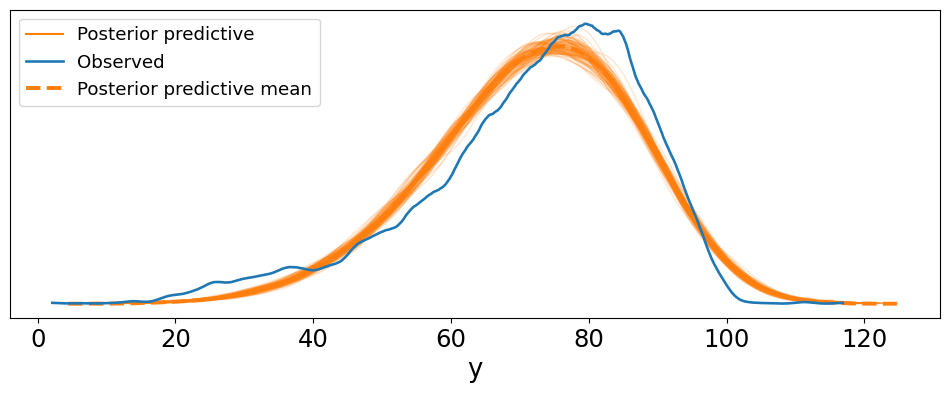

In [18]:
az.plot_ppc(h_hp_samples, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

And.. it looks the exact same, however it didn't throw a ton of errors so thats a good sign.

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'k_mu'}>,
        <Axes: title={'center': 'k_mu'}>],
       [<Axes: title={'center': 'k_sigma'}>,
        <Axes: title={'center': 'k_sigma'}>],
       [<Axes: title={'center': 'l'}>, <Axes: title={'center': 'l'}>],
       [<Axes: title={'center': 'l_alpha'}>,
        <Axes: title={'center': 'l_alpha'}>],
       [<Axes: title={'center': 'l_beta'}>,
        <Axes: title={'center': 'l_beta'}>]], dtype=object)

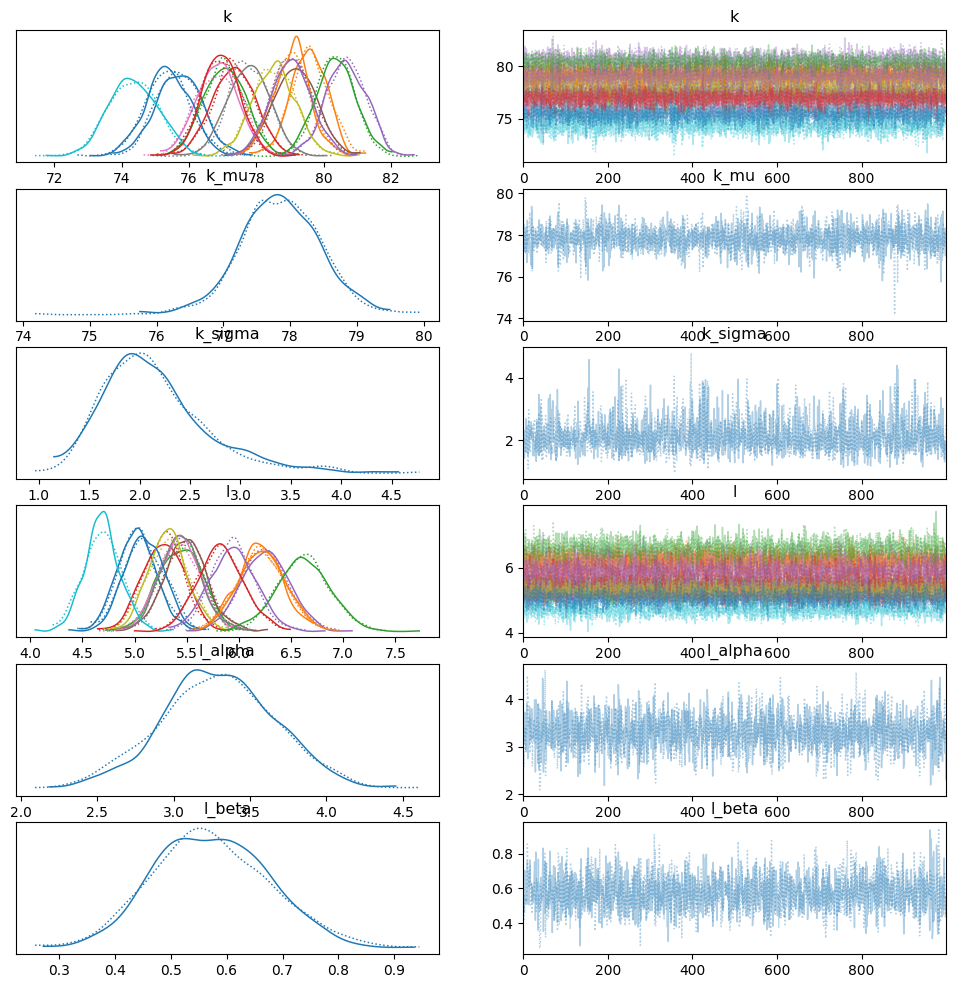

In [19]:
az.plot_trace(h_hp_samples)

In [20]:
az.rhat(h_hp_samples).to_dataarray().to_numpy()

array([[1.00013408, 1.00047054, 1.0015981 , 1.0002422 , 0.99989854,
        1.00063123, 1.00561541, 0.9999585 , 1.000032  , 0.99924419,
        1.00044339, 1.00069969, 1.00052076, 1.00134426, 0.99999182],
       [1.0055494 , 1.0055494 , 1.0055494 , 1.0055494 , 1.0055494 ,
        1.0055494 , 1.0055494 , 1.0055494 , 1.0055494 , 1.0055494 ,
        1.0055494 , 1.0055494 , 1.0055494 , 1.0055494 , 1.0055494 ],
       [0.99949466, 0.99949466, 0.99949466, 0.99949466, 0.99949466,
        0.99949466, 0.99949466, 0.99949466, 0.99949466, 0.99949466,
        0.99949466, 0.99949466, 0.99949466, 0.99949466, 0.99949466],
       [0.99983025, 1.00037696, 0.99938233, 1.00127443, 1.00548852,
        0.99988074, 1.00142266, 1.00152622, 1.00310317, 1.00237375,
        1.00099342, 1.00092487, 0.99937518, 0.99999074, 1.00206379],
       [1.00047363, 1.00047363, 1.00047363, 1.00047363, 1.00047363,
        1.00047363, 1.00047363, 1.00047363, 1.00047363, 1.00047363,
        1.00047363, 1.00047363, 1.00047363, 

There trace and rhat values are emaculate, so I'd say this run was a much greater success. Something about the values being interrelated fixed alot of the problems, and if I had to guess, it prevwented the program from getting stuck on countries with wierd shapes, and instead being forced to find general trends

array([<Axes: >], dtype=object)

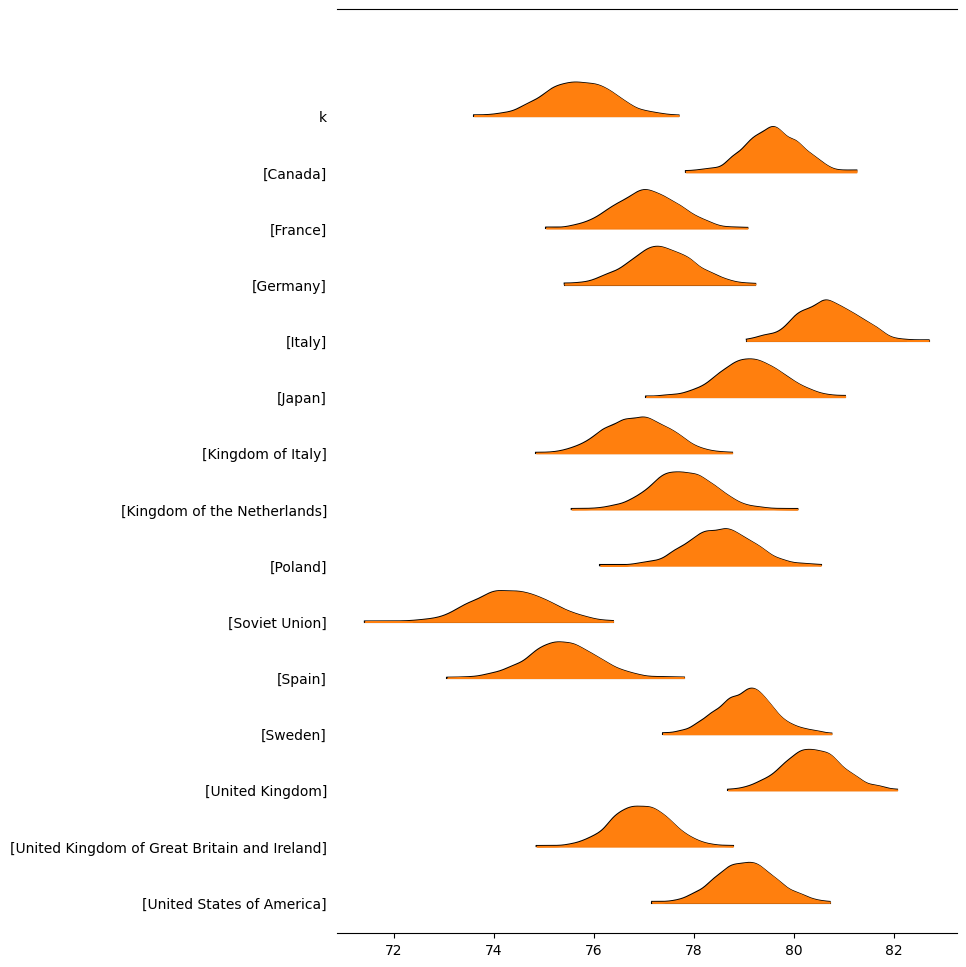

In [21]:
az.plot_forest(h_hp_samples, var_names=['k'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C1"], figsize=(8, 12))

array([<Axes: >], dtype=object)

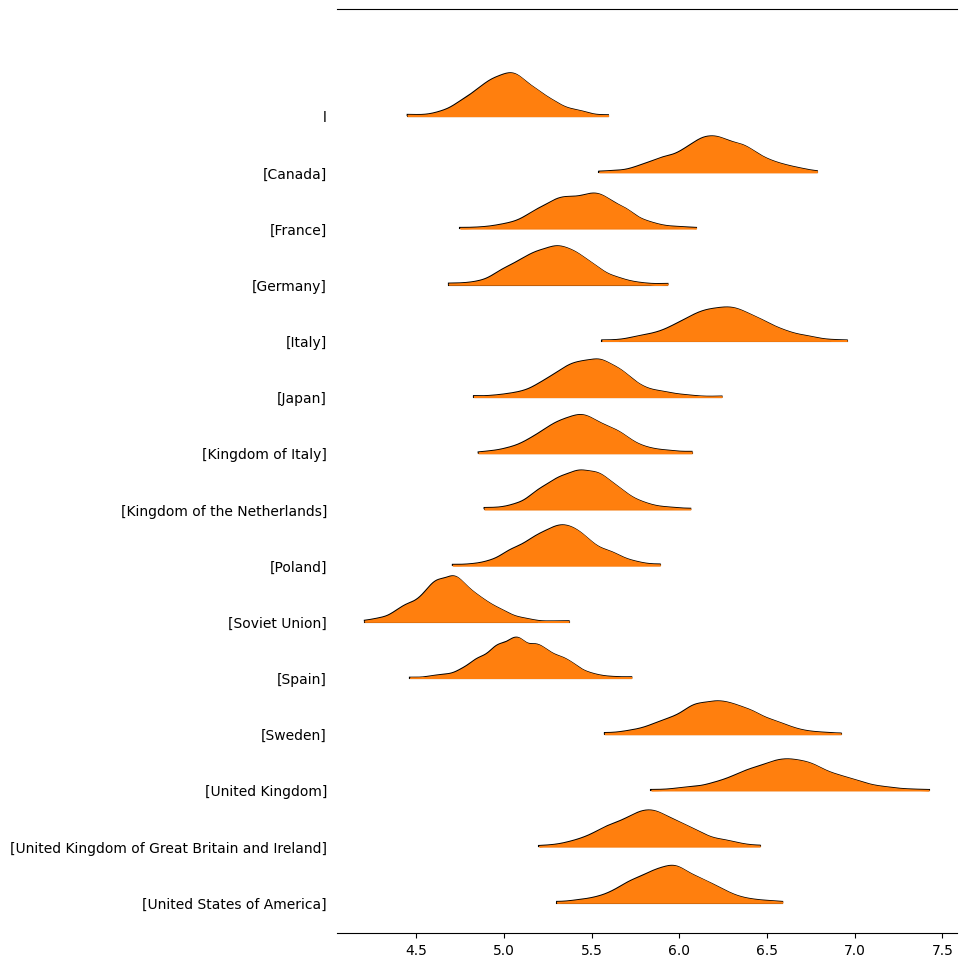

In [22]:
az.plot_forest(h_hp_samples, var_names=['l'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C1"], figsize=(8, 12))

If I had to guess, these smoother more focused graphs sugguest that the model found a solution better than it did prior.

# Final Comparisons

array([<Axes: >], dtype=object)

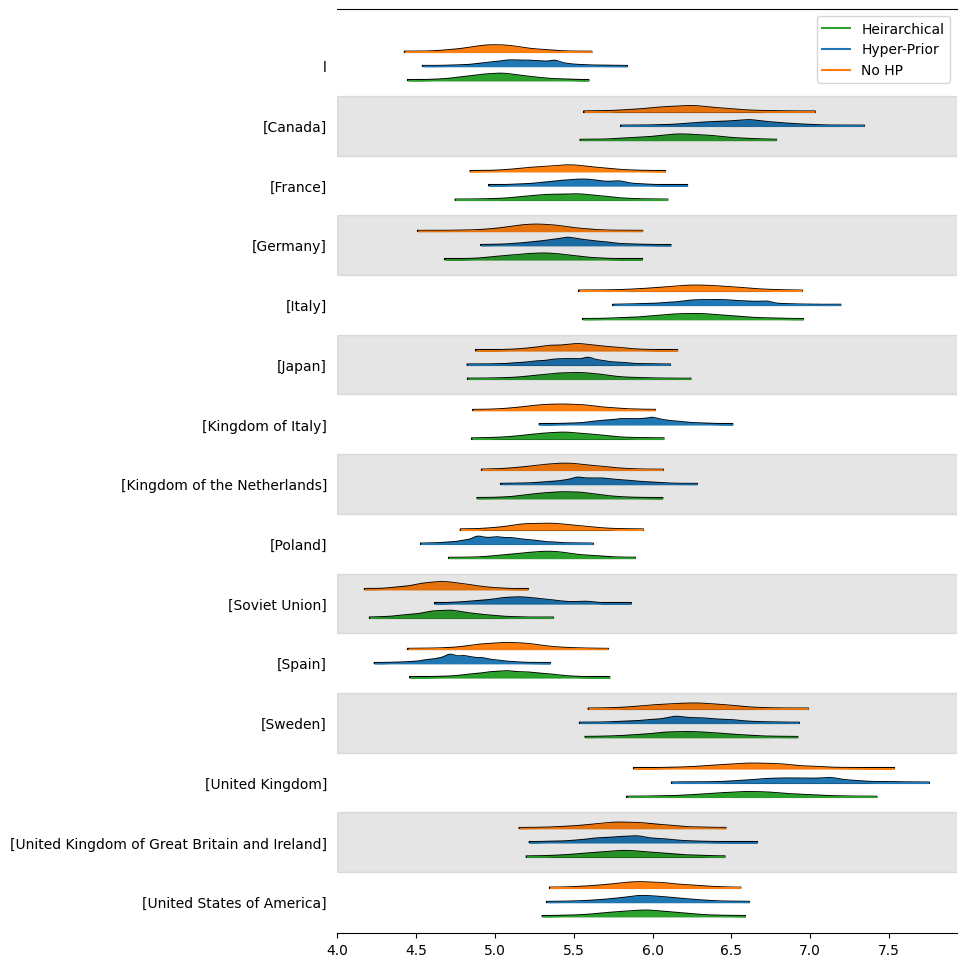

In [56]:
az.plot_forest([samples, hp_samples, h_hp_samples], model_names=['No HP', 'Hyper-Prior', 'Heirarchical'], var_names=['l'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C2"], figsize=(8, 12))

array([<Axes: >], dtype=object)

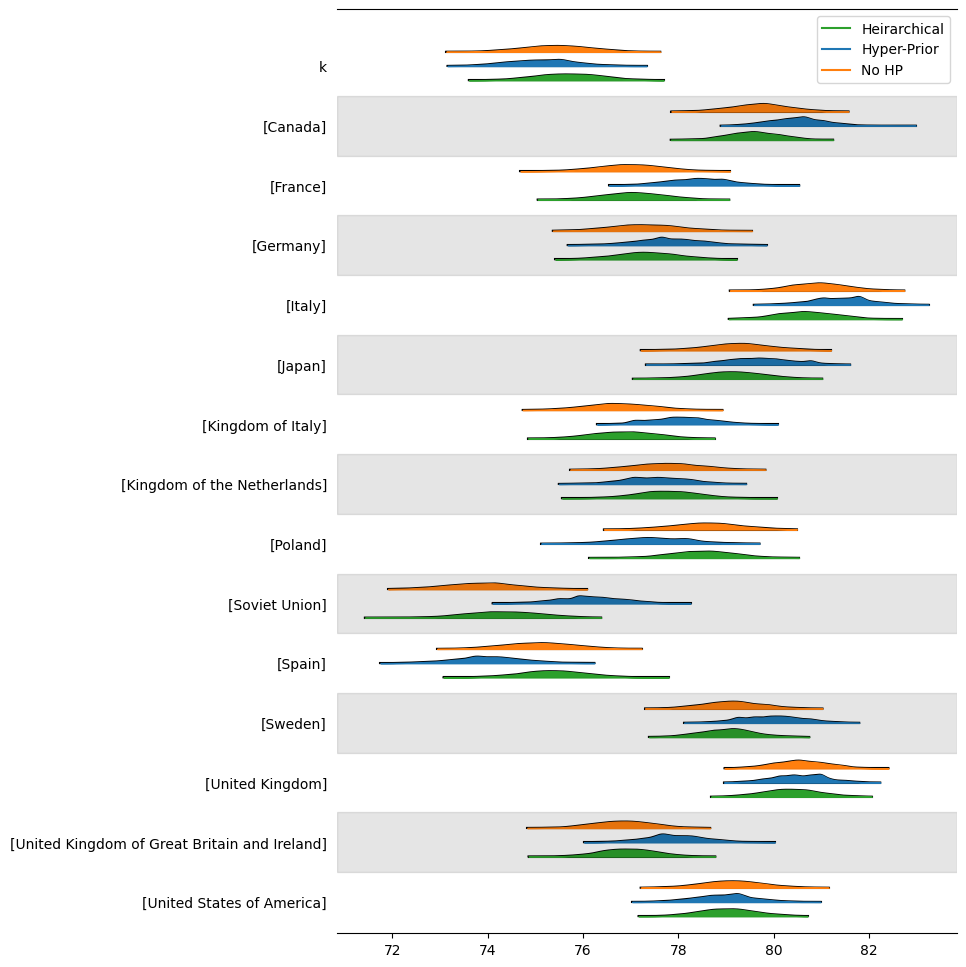

In [57]:
az.plot_forest([samples, hp_samples, h_hp_samples], model_names=['No HP', 'Hyper-Prior', 'Heirarchical'], var_names=['k'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C2"], figsize=(8, 12))

# Take 2?

Ok, so looking at this comparison, its awfully odd that my heirarchical model acts alot like my simple model, and given how many divergences occured, I decided to do one last attempt, this time changing my hyper prior for sigma to be a gamma distribution, as it will tend to be around what I estimated it to be earlier, and tend towards zero less.

<Axes: >

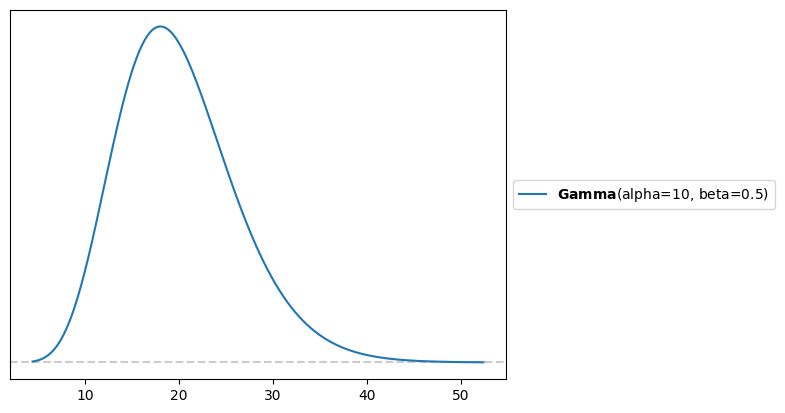

In [7]:
pz.Gamma(10, .5).plot_pdf() #Distribution for stdevs of mean age of death

<Axes: >

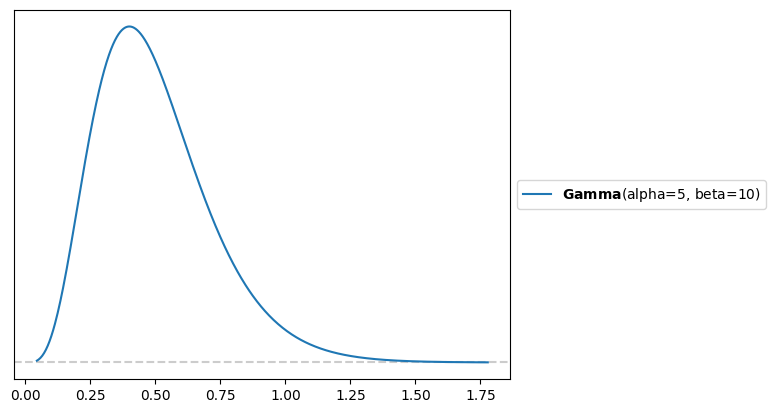

In [8]:
pz.Gamma(5, 10).plot_pdf() #Distribution for beta parameter to gamma

I'll just re-use my heriarical model's code here since it worked well, but I'll patch my hyperpriors using distributions that make a bit more sense

In [14]:
#Define our model using the python `with` syntax
with pm.Model(coords = coords) as h_hp_model_2:
  k_mu = pm.Normal('k_mu', mu = 70, sigma = 20)
  k_sigma = pm.Gamma('k_sigma', 10, .5)

  l_alpha = pm.Normal('l_alpha', mu = 3, sigma = .4)
  l_beta = pm.Gamma('l_beta', 5, 10)

  k = pm.Normal('k', mu = k_mu, sigma = k_sigma, dims = 'cc')
  l = pm.Gamma('l', l_alpha, l_beta, dims = 'cc')

  y = pm.Weibull('y', alpha = l[idx], beta = k[idx], observed = frame[0])

  h_hp_samples_2 = pm.sample(target_accept=.95)

Output()

Output()

array([<Axes: >], dtype=object)

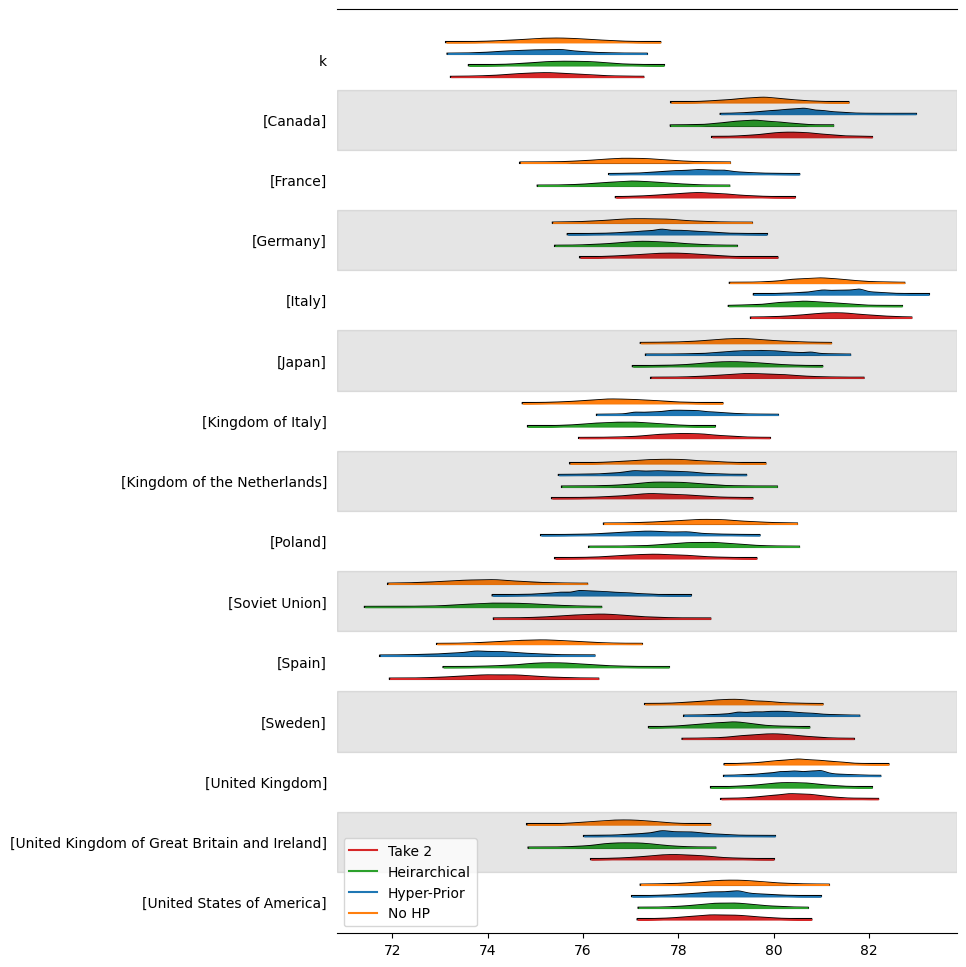

In [65]:
az.plot_forest([samples, hp_samples, h_hp_samples, h_hp_samples_2], model_names=['No HP', 'Hyper-Prior', 'Heirarchical', 'Take 2'], var_names=['k'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C2", "C3"], figsize=(8, 12))

Ok, wow, that run much faster and better. However, when plotted against the others we again see this new oddity, which is our Take-2 model agreeing with our Non-Heirarchical Hyper-Prior model, and not the heirarchical one.

If I had to guess, what I suspect is that the heirarchical model solved the digergences by using some countries to guide the solutions to others which game a similar result to the first one, but when we fixed our hyperpriors, we get a closer solution to our non-heirarical one, but minus the problems that plagued it.

Output()

<Axes: xlabel='y'>

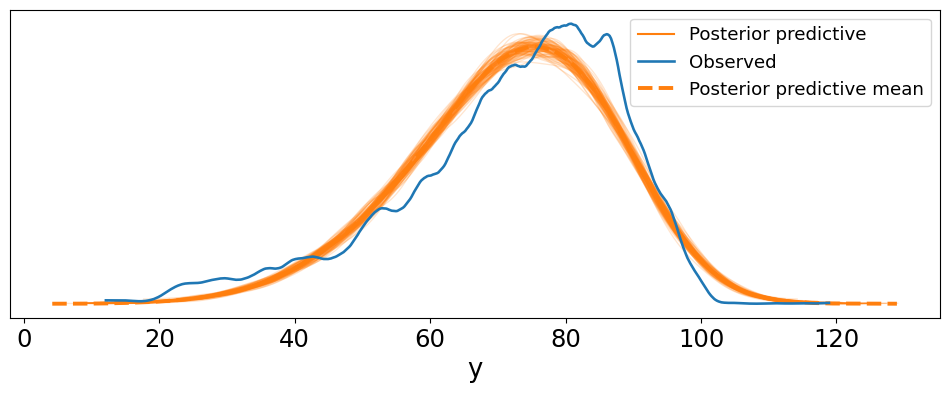

In [16]:
pm.sample_posterior_predictive(h_hp_samples_2, model=h_hp_model_2, extend_inferencedata=True)
az.plot_ppc(h_hp_samples_2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Looking at our PPC, it looks about the same as any of the other predictions I've seen, so I can't say if this better prior is truely better. However, in my opinion, having fixed divergencies and also using a heirarcicial model makes me think that this is probably the better predictor.